*Note - Due to Twitter's terms of use, the hydrated tweet data cannot be shared. Therefore, this notebook is provided as a PDF in order to share the model training process.*

In [38]:
import sys
import os
import json
import dill
import csv

import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

<h1 style="text-alight:center;"><p style="text-align: center;">Learn These Headline-Writing Tips - Before Your Competitors Do!</p> </h1>
<h3  style="text-alight:center;"><p style="text-align: center;"><span style="color:#1DA1F2">Or, Is All That Clickbait Worth All That Pain?</span></p> </h3>
<h4><p style="text-align:center;">Alexander Wood</p></h4>


In the United States, at least 82% of adults get at least some of their news online. However, the article tagline posted social media does not always match the article's full headline on the news site itself. Sometimes, It is simply a shortened version of the actual headline, reduced for character limits.

Other times, the headline is modified to be misleading about article contents or controversial in order to attract clicks - aka CLICKBAIT

CLICKS ARE IMPORTANT!
By 2014, more than 2/3 of all domestic news revenue was generated by ad revenue [source]. 

In fact, digital advertising was a $108 billion dollar industry in 2018.

However, in this age of "fake news" and propaganda, a news org must be careful to maintain a level of trust from its readers

I will answer the question, in what ways 

## Data Round 1: Training a Classifier

Let's go ahead and load the data. Note that due to Twitter's terms of use, I cannot share 'Hydrated' Tweet data. However, you can easily [download the tweet IDs]() and hydrate the tweets using:

* [This tweet Hydrator module]((https://github.com/alexanderwood/hydrate-tweets-api-v2)) I wrote for this project. This module allows you to query Twitter's Developer API v2 for comprehensive tweet information in batches of tweet IDs using the [Tweet endpoint](https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/api-reference/get-tweets#requests). Instructions are available in the project's repository - note you will need access to the new(er) Twitter Developer API v2
* [My script for hydrating this dataset](https://github.com/alexanderwood/wood-clickbait/blob/master/code/hydrate-webis.py) could be easily adapted for personal use. 

In [39]:
# Load data
fpath = Path.cwd().parent.parent / 'data' / 'webis-clickbait-17' 

In [40]:
# Load the data
# Load the targets variables. 
import json


def load_features():
    '''Load the dataset'''
    
    # MUST SPECIFY DTYPES - PANDAS BUG LARGE NUMERIC STRINGS 
    X = pd.read_csv(fpath /'tweets-clean.csv' , index_col=0,
                   dtype={'tweet_id': str, 
                          'author_id': str, 
                          'name': str, 
                          'username': str, 
                          'timestamp': str, 
                          'retweets': np.int64,
                          'replies': np.int64, 
                          'likes': np.int64, 
                          'quotes': np.int64, 
                          'text': str, 
                          'url': str})
    X[['text']] = X.apply(lambda x: x.text.split('http')[0].rstrip(), axis=1)  # Clean text/remove URLs
    X = X.drop_duplicates(subset='tweet_id', ignore_index=True)  # Drop duplicate IDs.

    return X


def load_targets():
    '''Load the target variables'''
     
    # MUST SPECIFY DTYPES - PANDAS BUG LARGE NUMERIC STRINGS 
    y = pd.read_json(fpath / 'raw-data' / 'truth.jsonl', 
                     lines=True,
                    dtype={'truthJudgments':list, 
                           'truthMean':np.float64, 
                           'id':str, 
                           'truthClass':str, 
                           'truthMedian':np.float64,
                           'truthMode':np.float64})
    y = y.rename(columns={'id':'tweet_id'})

    # Split the judges' scores into their own columns.
    cols = ['score1', 'score2', 'score3', 'score4']
    for i in range(len(cols)):
        y[[cols[i]]] = y[['truthJudgments']].apply(lambda x: x.truthJudgments[i],axis=1)

    return y

def load_data():
    X = load_features()
    y = load_targets()
    
    # Combined dataframe. 
    df = X.merge(y, left_on='tweet_id', right_on='tweet_id')
    
    return df


df = load_data()

## Data Exploration

We have $19,503$ tweets annotated by four different annotators. Let's look at how 'clickbaity' the data is within the dataset.

In [41]:
df.head()

,tweet_id,author_id,name,username,timestamp,retweets,replies,likes,quotes,text,url,truthJudgments,truthMean,truthClass,truthMedian,truthMode,score1,score2,score3,score4
0,858462320779026433,16973333,The Independent,Independent,2017-04-29T23:25:41.000Z,29,1,9,3,UK’s response to modern slavery leaving victim...,https://t.co/1lO8GUCiOC,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000,0.333333,0.000000,0.333333,0.0
1,858421020331560960,457984599,Breitbart News,BreitbartNews,2017-04-29T20:41:34.000Z,94,16,285,2,this is good,https://www.breitbart.com/politics/2017/04/28/...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,858368123753435136,2467791,The Washington Post,washingtonpost,2017-04-29T17:11:23.000Z,130,33,237,11,"The ""forgotten"" Trump roast: Relive his brutal...",https://www.washingtonpost.com/news/arts-and-e...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333,0.333333,1.000000,0.333333,0.0
3,858323428260139008,191768572,Indiatimes,indiatimes,2017-04-29T14:13:46.000Z,1,0,1,0,Meet the happiest #dog in the world!,https://t.co/XSdyX0bfoL,"[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.933333,clickbait,1.000000,1.000000,1.000000,0.666667,1.000000,1.0
4,858283602626347008,15438913,Daily Mail Online,MailOnline,2017-04-29T11:35:31.000Z,120,8,47,14,Tokyo's subway is shut down amid fears over an...,https://t.co/zWnqbaE68o,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


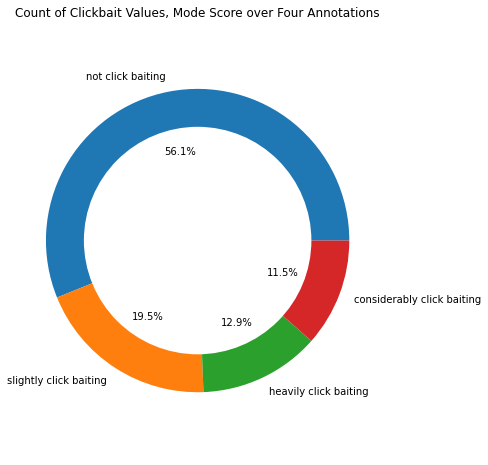

In [42]:
def plot_ring(col, title, labels):
    
    sizes = df[col].value_counts()
    colors = ['#ff99aa','#66b3ff','#99ff99','#ffcc22']

    # print(sizes) # adds up to 1433, which is the total number of participants
    fig1, ax1 = plt.subplots()
    fig1.set_figheight(8)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax1.axis('equal')

    # Plot circle.
    centre_circle = plt.Circle((0,0), 0.75, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(title)
    plt.show()
    
    
score_name = 'Mode'
title = "Count of Clickbait Values, {} Score over Four Annotations".format(score_name)
labels = ['not click baiting', 'slightly click baiting', 'heavily click baiting', 'considerably click baiting']  

plot_ring('truthMode', title, labels)

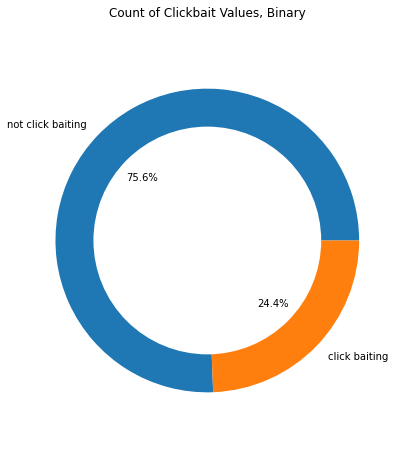

In [43]:
title = "Count of Clickbait Values, Binary"
labels = ['not click baiting', 'click baiting']  

plot_ring('truthClass', title, labels)

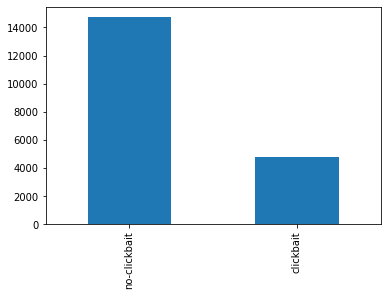

In [44]:
df['truthClass'].value_counts().plot(kind='bar');
#sns.barplot(data=df.truthClass.value_counts(), random_state=42)

## Model Training 

Each model takes as input the text of the tweet and returns a classification as clickbait or not clickbait. Let's start with viewing this as a binary classification problem. The binary classifications are given in the `truthClass` column, with values `no-clickbait` or `clickbait`. The text is in the `text` column. 

We are going to take a quarter of the data and set it aside as the holdout test set. 

In [45]:
from sklearn.model_selection import train_test_split

X, X_val, y, y_val = train_test_split(df[['text']], df[['truthClass']], 
                                      test_size = 0.25,
                                      shuffle=True,
                                      stratify=df[['truthClass']],
                                      random_state=420)


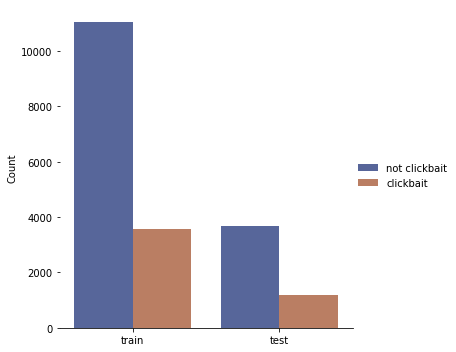

In [46]:
# Draw a nested barplot by count of each target variable in train and test sets
dat = pd.DataFrame([
    ['train', y.value_counts()[0], 'not clickbait'], 
    ['train', y.value_counts()[1], 'clickbait'],
    ['test', y_val.value_counts()[0], 'not clickbait'],
    ['test', y_val.value_counts()[1], 'clickbait']],
    columns=['Set', 'Count', 'Clickbait Value']
)


g = sns.catplot(
    data=dat, kind="bar",
    x="Set", y="Count", 
    hue="Clickbait Value",
    palette="dark", alpha=.7, height=5,
    ci=None
)

g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")

As we can see, the ratio of clickbait to non-clickbait is about equal in the test and train sets. However, the data is class imbalanced. We will need to keep a careful eye on this during model training. 

In [47]:
# Positive label: clickbait
y = (y.values == 'clickbait').ravel().astype(np.int16)
y_val = (y_val.values == 'clickbait').ravel().astype(np.int16)

### The Data 


In [48]:
from sklearn import base

from sklearn.metrics import (classification_report, make_scorer, 
                             accuracy_score, confusion_matrix,
                             plot_confusion_matrix)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

In [49]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    '''
    Returns an array containing the selected keys of a feature matrix.
    '''
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        tmp = X[self.col_names].values
        return [t[0] for t in tmp]
   


In [50]:
def display_confusion(classifier, X, y, fname='output.svg'):
    '''
    Tool for displaying side-by-side confusion matrix / normalized confusion matrix for 
    a classifier and testing data. 
    '''
    titles_options = [("Confusion matrix", None, 1),
                      ("Normalized Confusion Matrix", 'true', 2)]
    
    fig = plt.figure(1)
    
    fig.set_figwidth(15)
    for title, normalize, i in titles_options:
        ax = plt.subplot(1,2,i)
        disp = plot_confusion_matrix(classifier, X, y,
                                     display_labels=['Not Clickbait','Clickbait'],
                                     cmap=plt.cm.BuGn,
                                     normalize=normalize,
                                     ax=ax
                                    )
        disp.ax_.set_title(title)
    fig.tight_layout()
    
    plt.show()   

        
def save_confusion(classifier, X, y, fname='output.svg'):
    '''
    Tool for displaying side-by-side confusion matrix / normalized confusion matrix for 
    a classifier and testing data. 
    '''
    titles_options = [("Confusion matrix", None, 1, 'confmat.svg'),
                      ("Normalized Confusion Matrix", 'true', 2, 'confmat-norm.svg')]
    titles=['confmat.svg', 'confmat-norm.svg']
    
    for title, normalize, i, fname in titles_options:
        fig = plt.figure(1)
        fig.set_figwidth(15)
        disp = plot_confusion_matrix(classifier, X, y,
                                     display_labels=['Not Clickbait','Clickbait'],
                                     cmap=plt.cm.BuGn,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        fig.tight_layout()
        plt.savefig(fname)


In [51]:
def cv_report(pipe):
    strout = "Best parameters:\n{}\n\nGrid Scores:"
    print(strout.format(pipe.best_params_))
    means = pipe.cv_results_['mean_test_score']
    stds = pipe.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, pipe.cv_results_['params']):
        print("{0:.3f} (+/-{1:.03f}) for {2!s}".format(mean, std * 2, params))
        


Let's put together a bare-bones Bare-bones stopword list comprised of the most common non-proper-noun words in the training corpus, as well as articles

In [52]:
stopwords = ['the', 'to', 'in', 'of', 'for', 'and', 'is', 'on', 'an', 'a'] 

We start with a simple, linear model, without fussing over normalizing or cleaning the data. This will be our benchmark model. Let's also set some debug options. 

In [53]:
# Set the debug options. 
# Models are not loaded or saved in debug mode. 

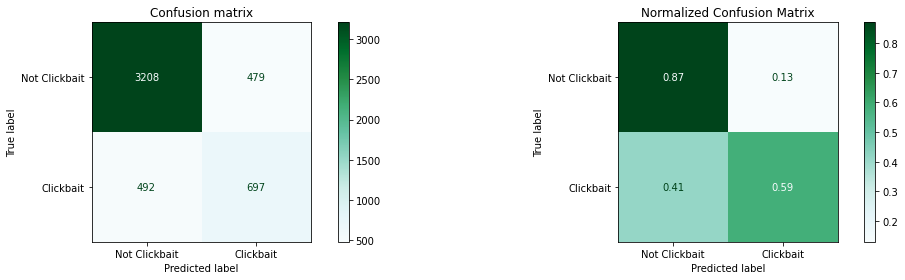

In [54]:
# Train (or load) model. 

DEBUG = True 
fname = Path.cwd().parent / 'models' / 'clf-counts.pkl'
scoring = {'f1': 'f1', 'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

if not DEBUG and os.path.exists(fname):
    with open(fname, "rb") as f:
        clf_counts = dill.load(f)
else:
    param_grid = [{'alpha':[0.0001, 0.001, 0.005, 0.01]}]
    gridcv = GridSearchCV(SGDClassifier(), param_grid, cv=10, scoring=scoring, refit='f1')
    clf_counts = Pipeline([
        ('transformer', ColumnSelectTransformer(['text'])),
        ("vectorizer", CountVectorizer()), # Vectorizer
        ("classifier", gridcv)# Regressor
    ])
    clf_counts.fit(X, y)
    
    if not DEBUG:
        with open(fname, "wb") as f:
            dill.dump(clf_cxounts, f)
    
    
display_confusion(clf_counts, X_val, y_val)

If we look at the normalized confusion matrix, we see quite clearly that this model is having a hard time correctly classifying clickbait - there is a high false negative rate. 

We would like to introduce some complexity to our model, as we are underfitting the data at present. There are multiple methods to do this:

1. Use $n$-grams for $n>1$.
2. Normalized vectorizer (eg, `Tfidf`)
3. Classifiers that account for class imbalance. 

### Model 2: Logistic Regression

For the next model, let's try a Logistic Regression model. We will use the `sag` solver for speed, and once again fit to F1-score rather than accuracy due to class imbalance. 

In [55]:
# Train (or load) model. 
from sklearn.linear_model import LogisticRegression

DEBUG = False
fname = Path.cwd().parent / 'models' / 'clf-logreg.pkl'
scoring = {'f1': 'f1', 'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

if not DEBUG and os.path.exists(fname):
    with open(fname, "rb") as f:
        clf_logreg = dill.load(f)
else:
    param_grid = [{'solver':['sag'], 'class_weight':['balanced'], 'tol':[0.001, 0.0001, 0.00001]}]
    gridcv = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring=scoring, refit='f1')
    clf_logreg = Pipeline([
        ('transformer', ColumnSelectTransformer(['text'])),
        ("vectorizer", TfidfVectorizer(ngram_range=(1,2,3), stop_words=stopwords)), # Vectorizer
        ("classifier", gridcv)# Regressor
    ])
    clf_logreg.fit(X, y)
    
    if not DEBUG:
        with open(fname, "wb") as f:
            dill.dump(clf_logreg, f)
    
    

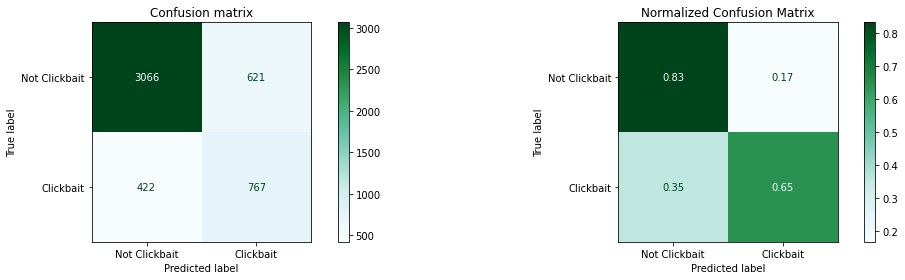

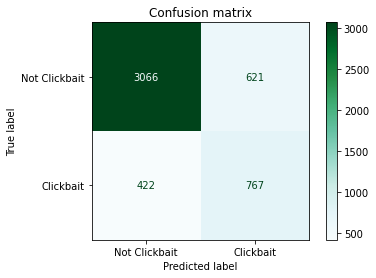

<Figure size 1080x288 with 0 Axes>

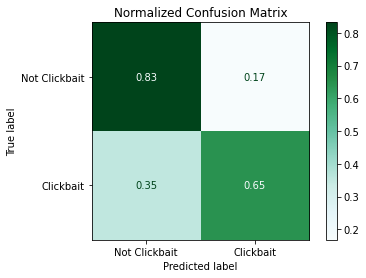

In [56]:
display_confusion(clf_logreg, X_val, y_val, 'confusion.svg')
save_confusion(clf_logreg, X_val, y_val)

We get the best results when we use up to 3-grams. 

In [57]:
y_pred = clf_logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3687
           1       0.55      0.65      0.60      1189

    accuracy                           0.79      4876
   macro avg       0.72      0.74      0.72      4876
weighted avg       0.80      0.79      0.79      4876



We have an F1-score of 0.86 and an accuracy of 0.79. This is a good start, and in fact is has a F1-score than the baseline during the [Clickbait Challenge 2017](https://arxiv.org/abs/1812.10847), suggesting this has a better of handling the class imbalance. 

## Data Round 2: Classifying our corpus

Now that we have a classifier, let's see how different news organizations compare to each other regarding clickbaitiness levels. 

In [58]:
orgs = ['abc', 'bbc', 'breitbart', 'cbs', 'cnn', 'fox', 'huffpo', 'msnbc', 'nbc', 'npr', 'nytimes', 'wapo', 'wsj']

In [59]:
def load_tweetset(org_handle):
    '''Load the dataset'''
    
    # MUST SPECIFY DTYPES - PANDAS BUG LARGE NUMERIC STRINGS 
    X = pd.read_csv(Path.cwd().parent.parent / 'data' / 'tweets' / 'tweet-hydrated' / '{}-2017.csv'.format(org_handle), index_col=None,
                   dtype={'tweet_id': str,
                          'author_id': str,
                          'name': str,
                          'username': str,
                          'timestamp': str,
                          'retweets': np.int64,
                          'replies': np.int64,
                          'likes': np.int64,
                          'quote_count': np.int64,
                          'text': str,
                          'url': str})

    print(org_handle+ '\t', X.shape, end="\t")
    X[['text']] = X.apply(lambda x: x.text.split('http')[0].rstrip(), axis=1)  # Clean text/remove URLs
    X = X.drop_duplicates(subset='tweet_id', ignore_index=True)  # Drop duplicate IDs.
    print(X.shape)
    return X


In [60]:
# Predict clickbaitiness score for each of the news orgs. 
# Predict clickbaitiness score for each of the news orgs. 
scores_prob = pd.DataFrame(columns=['tweet_id', 'author_id', 'author_name', 'author_handle', 'created_at', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'text', 'url']+['bait_proba', 'nonbait_proba'])
print('Handle', '\# Tweets', '\# Valid Tweets', sep='\t')
for org in orgs:
    df = load_tweetset(org)
    data_pred = clf_logreg.predict_proba(df)
    df['bait_proba'] = [d[1] for d in data_pred]
    df['nonbait_proba'] = [d[0] for d in data_pred]
    df['scores'] = ['clickbait' if d[1] >= 0.5 else 'non-clickbait' for d in data_pred]
    scores_prob = scores_prob.append(df)

scores_prob.head()

Handle	\# Tweets	\# Valid Tweets
abc	 (31083, 11)	(31083, 11)
bbc	 (12651, 11)	(12651, 11)
breitbart	 (6878, 11)	(6878, 11)
cbs	 (34263, 11)	(34263, 11)
cnn	 (47796, 11)	(47796, 11)
fox	 (36566, 11)	(36566, 11)
huffpo	 (14125, 11)	(10025, 11)
msnbc	 (10269, 11)	(10269, 11)
nbc	 (9431, 11)	(9431, 11)
npr	 (7812, 11)	(7812, 11)
nytimes	 (36946, 11)	(36946, 11)
wapo	 (45349, 11)	(45349, 11)
wsj	 (43272, 11)	(43272, 11)


,tweet_id,author_id,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,text,url,bait_proba,nonbait_proba,scores
0,888023039576879104,28785486,ABC News,ABC,2017-07-20T13:09:25.000Z,34,9,29,11,O.J. Simpson is set to face a Nevada parole bo...,https://t.co/2tEOLfJ2CK,0.233541,0.766459,non-clickbait
1,887959662573887488,28785486,ABC News,ABC,2017-07-20T08:57:35.000Z,21,30,38,9,Pres. Trump issues statement on McCain's brain...,https://t.co/JkClGl19MM,0.159754,0.840246,non-clickbait
2,887920778892660736,28785486,ABC News,ABC,2017-07-20T06:23:05.000Z,346,29,978,32,Stunning video captures a young whale 'dancing...,https://t.co/O0pXTKVqV6,0.436111,0.563889,non-clickbait
3,887912731742949377,28785486,ABC News,ABC,2017-07-20T05:51:06.000Z,353,248,303,128,Utility worker's cellphone video shows South F...,https://t.co/O0pXTKVqV6,0.108897,0.891103,non-clickbait
4,887822026739781632,28785486,ABC News,ABC,2017-07-19T23:50:40.000Z,70,9,79,11,Minnesota teen who ran away from home in 1976 ...,https://t.co/kUDijG2FIi,0.252621,0.747379,non-clickbait


In [61]:
scores_prob[scores_prob.author_handle=='nytimes'].head()

,tweet_id,author_id,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,text,url,bait_proba,nonbait_proba,scores
0,882207618890166273,807095,The New York Times,nytimes,2017-07-04T12:01:01.000Z,45,13,158,14,"A break-neck backstage tour of the Met Opera, ...",https://t.co/N7UTHKIJs7,0.225993,0.774007,non-clickbait
1,882132782184620032,807095,The New York Times,nytimes,2017-07-04T07:03:39.000Z,165,64,163,39,North Korea Says It Has Successfully Tested ICBM,https://t.co/Tp5Fq1tV48,0.060109,0.939891,non-clickbait
2,882096325403320320,807095,The New York Times,nytimes,2017-07-04T04:38:47.000Z,74,55,144,10,Tehran Journal: Why Are These Iranians ‘Really...,https://t.co/suPuiTvyjn,0.822935,0.177065,clickbait
3,882064225543303169,807095,The New York Times,nytimes,2017-07-04T02:31:13.000Z,152,106,227,45,Breaking News: Gov. Chris Christie and the New...,https://t.co/KXgPwELnwl,0.255252,0.744748,non-clickbait
4,881942637372166144,807095,The New York Times,nytimes,2017-07-03T18:28:05.000Z,63,12,155,13,"What do Ohio State, Williams College and Loyol...",https://t.co/iZc9VAoFFq,0.560583,0.439417,clickbait


In [62]:
scores = scores_prob[['author_name', 'author_handle', 'scores']].value_counts().sort_index().unstack(level=2)
scores.head(13)

,scores,clickbait,non-clickbait
author_name,author_handle,,
ABC News,ABC,2444,28639
BBC News (World),BBCWorld,1264,11387
Breitbart News,BreitbartNews,3751,3127
CBS News,CBSNews,3770,30493
CNN,CNN,9086,38710
Fox News,FoxNews,5276,31290
HuffPost,HuffPost,2174,7851
MSNBC,MSNBC,1334,8935
NBC News,NBCNews,1580,7851


In [63]:
for name, handle in zip(np.unique(scores_prob.author_name.values).tolist(), np.unique(scores_prob.author_handle.values).tolist()):
    print('<a class="dropdown-item" href="/dashboard/{}">{}</a>'.format(handle, name))

<a class="dropdown-item" href="/dashboard/ABC">ABC News</a>
<a class="dropdown-item" href="/dashboard/BBCWorld">BBC News (World)</a>
<a class="dropdown-item" href="/dashboard/BreitbartNews">Breitbart News</a>
<a class="dropdown-item" href="/dashboard/CBSNews">CBS News</a>
<a class="dropdown-item" href="/dashboard/CNN">CNN</a>
<a class="dropdown-item" href="/dashboard/FoxNews">Fox News</a>
<a class="dropdown-item" href="/dashboard/HuffPost">HuffPost</a>
<a class="dropdown-item" href="/dashboard/MSNBC">MSNBC</a>
<a class="dropdown-item" href="/dashboard/NBCNews">NBC News</a>
<a class="dropdown-item" href="/dashboard/NPR">NPR</a>
<a class="dropdown-item" href="/dashboard/WSJ">The New York Times</a>
<a class="dropdown-item" href="/dashboard/nytimes">The Wall Street Journal</a>
<a class="dropdown-item" href="/dashboard/washingtonpost">The Washington Post</a>


In [64]:
full_names = scores.index.values.tolist()

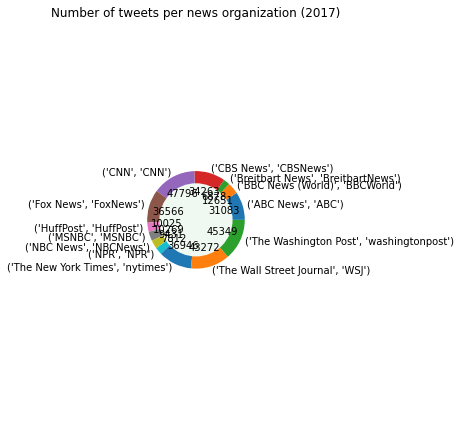

In [65]:
def plot_ring(title, labels, heights):
    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format

    N = 2
    #colors = ['#ff99aa','#66b3ff','#99ff99','#ffcc22']
    # print(sizes) # adds up to 1433, which is the total number of participants
    fig1, ax1 = plt.subplots()
    fig1.set_figheight(6)
    ax1.pie(heights, labels=labels, autopct=autopct_format(heights))
    ax1.axis('equal')

    # Plot circle.
    centre_circle = plt.Circle((0,0), 0.75, fc='#F0F9F1')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(title)
    plt.tight_layout()
    plt.savefig("tweet-count-by-org.svg")
    plt.show()


num_tweets_by_org = scores_prob.author_name.value_counts().sort_index().to_numpy()
score_name = 'Mode'
title = "Number of tweets per news organization (2017)".format(score_name)
#labels = ['not click baiting', 'slightly click baiting', 'heavily click baiting', 'considerably click baiting']  

plot_ring(title, full_names, num_tweets_by_org)

with open("tweet_count_by_org.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(full_names)
    w.writerow(num_tweets_by_org)

In [74]:
scores.index.values

array([('ABC News', 'ABC'), ('BBC News (World)', 'BBCWorld'),
       ('Breitbart News', 'BreitbartNews'), ('CBS News', 'CBSNews'),
       ('CNN', 'CNN'), ('Fox News', 'FoxNews'), ('HuffPost', 'HuffPost'),
       ('MSNBC', 'MSNBC'), ('NBC News', 'NBCNews'), ('NPR', 'NPR'),
       ('The New York Times', 'nytimes'),
       ('The Wall Street Journal', 'WSJ'),
       ('The Washington Post', 'washingtonpost')], dtype=object)

In [75]:
x = [(org[0], val) for org in scores.index.values for val in ['clickbait', 'non-clickbait']]
counts = scores.to_numpy().flatten().tolist()
counts

[2444,
 28639,
 1264,
 11387,
 3751,
 3127,
 3770,
 30493,
 9086,
 38710,
 5276,
 31290,
 2174,
 7851,
 1334,
 8935,
 1580,
 7851,
 1769,
 6043,
 10992,
 25954,
 7248,
 36024,
 10786,
 34563]

In [76]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FactorRange, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

[('ABC News', 'ABC'),
 ('BBC News (World)', 'BBCWorld'),
 ('Breitbart News', 'BreitbartNews'),
 ('CBS News', 'CBSNews'),
 ('CNN', 'CNN'),
 ('Fox News', 'FoxNews'),
 ('HuffPost', 'HuffPost'),
 ('MSNBC', 'MSNBC'),
 ('NBC News', 'NBCNews'),
 ('NPR', 'NPR'),
 ('The New York Times', 'nytimes'),
 ('The Wall Street Journal', 'WSJ'),
 ('The Washington Post', 'washingtonpost')]

In [78]:
output_notebook()
palette = [ "#321fdb", "#f9b115"]
source = ColumnDataSource(data=dict(x=x, counts=counts))

# Hover tools
tooltips = [
    ("Org", "$x[0]"),
    ("B", "($x, $y)"),
]

p = figure(x_range=FactorRange(*x), plot_height=350, title="Tweet Counts By Year",
           tooltips=tooltips, toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white",
       fill_color=factor_cmap('x', palette=palette, factors=['non-clickbait', 'clickbait'], start=1, end=2))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None

#show(p)  # Didn't like this one

Loading BokehJS ...

In [79]:
percent_bait_by_org = (scores['clickbait'] / num_tweets_by_org).tolist()
percent_nonbait_by_org = (-1 * scores['non-clickbait'] / num_tweets_by_org).tolist()
cds_bait = ColumnDataSource(data=dict(names=full_names, vals=percent_bait_by_org))
cds_nonbait = ColumnDataSource(data=dict(names=full_names, vals=percent_nonbait_by_org))

In [80]:

output_notebook()
sections = ['clickbait', 'non-clickbait']

p = figure(
    y_range=full_names, 
    plot_height=350, 
    x_range=(-1, 1), 
    title="Percentage of clickbait & non-clickbait Posts by organization",
    toolbar_location=None)

lbl = ['clickbait', 'non-clickbait']
p.hbar_stack(['vals'], y='names', height=0.9, color='#243447', source=cds_nonbait,
             legend_label=['Non-Clickbait'])
p.hbar_stack(['vals'], y='names', height=0.9, color='#FDAC53', source=cds_bait,
             legend_label=['Clickbait'])
p.y_range.range_padding = 0.1
p.xgrid.grid_line_color, p.ygrid.grid_line_color = None, None
p.axis.major_tick_line_color, p.axis.minor_tick_line_color = None, None
p.legend.location = "top_right"
p.axis.axis_line_color=None
p.outline_line_color = None
p.xaxis.ticker = []
p.title.text_color="#141D26"
p.yaxis.axis_label_text_color = "#141D26"

show(p)

Loading BokehJS ...

ValueError: Unrecognized range input: '[('ABC News', 'ABC'), ('BBC News (World)', 'BBCWorld'), ('Breitbart News', 'BreitbartNews'), ('CBS News', 'CBSNews'), ('CNN', 'CNN'), ('Fox News', 'FoxNews'), ('HuffPost', 'HuffPost'), ('MSNBC', 'MSNBC'), ('NBC News', 'NBCNews'), ('NPR', 'NPR'), ('The New York Times', 'nytimes'), ('The Wall Street Journal', 'WSJ'), ('The Washington Post', 'washingtonpost')]'

In [54]:
import csv
with open("perc_by_org.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow([f[0] for f in full_names])
    writer.writerow(percent_nonbait_by_org)
    writer.writerow(percent_bait_by_org)

In [89]:
total_values = scores.to_numpy().transpose()
with open("count_by_org.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([f[1] for f in full_names])
    writer.writerows(total_values)

# Further data exploration

Let's explore the data further by interations.

In [33]:
df = scores_prob[['author_name', 'author_handle', 'created_at', 'retweet_count', 'reply_count', 
                  'like_count', 'quote_count', 'bait_proba']]

df.head()

,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,bait_proba
0,ABC News,ABC,2017-07-20T13:09:25.000Z,34,9,29,11,0.233541
1,ABC News,ABC,2017-07-20T08:57:35.000Z,21,30,38,9,0.159754
2,ABC News,ABC,2017-07-20T06:23:05.000Z,346,29,978,32,0.436111
3,ABC News,ABC,2017-07-20T05:51:06.000Z,353,248,303,128,0.108897
4,ABC News,ABC,2017-07-19T23:50:40.000Z,70,9,79,11,0.252621


In [34]:
df.to_csv('csv/data_classified.csv')

In [35]:
tmp = df[df.author_name=='MSNBC']
tmp.head()

,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,bait_proba
0,MSNBC,MSNBC,2017-07-19T13:30:26.000Z,96,90,116,8,0.239290
1,MSNBC,MSNBC,2017-02-22T19:00:16.000Z,41,156,45,65,0.190261
2,MSNBC,MSNBC,2017-06-01T14:00:17.000Z,239,315,415,64,0.196405
3,MSNBC,MSNBC,2017-06-01T03:00:08.000Z,82,84,103,4,0.290986
4,MSNBC,MSNBC,2017-04-19T05:14:49.000Z,126,143,285,31,0.253762


In [36]:
tmp[tmp.bait_proba >= .5].head()

,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,bait_proba
14,MSNBC,MSNBC,2017-01-20T01:00:29.000Z,8,24,10,8,0.598758
15,MSNBC,MSNBC,2017-01-19T21:31:06.000Z,100,44,363,14,0.728181
21,MSNBC,MSNBC,2017-09-18T21:00:34.000Z,11,10,15,1,0.816263
23,MSNBC,MSNBC,2017-04-26T15:30:08.000Z,50,99,89,16,0.502858
26,MSNBC,MSNBC,2017-02-08T02:28:35.000Z,5,32,38,6,0.516905


In [37]:
tmp[tmp.bait_proba < .5].head()

,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,bait_proba
0,MSNBC,MSNBC,2017-07-19T13:30:26.000Z,96,90,116,8,0.239290
1,MSNBC,MSNBC,2017-02-22T19:00:16.000Z,41,156,45,65,0.190261
2,MSNBC,MSNBC,2017-06-01T14:00:17.000Z,239,315,415,64,0.196405
3,MSNBC,MSNBC,2017-06-01T03:00:08.000Z,82,84,103,4,0.290986
4,MSNBC,MSNBC,2017-04-19T05:14:49.000Z,126,143,285,31,0.253762


In [84]:
df = pd.read_csv('csv/data_classified.csv')
df['score'] = df.bait_proba.transform(lambda x: int(x>=0.5))
df['created_at'] = df.created_at.transform(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
df['month'] = df.created_at.transform(lambda x: x.month)
df['day'] = df.created_at.transform(lambda x: x.day)
df.head(100)

,Unnamed: 0,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,bait_proba,score,month,day
0,0,ABC News,ABC,2017-07-20 13:09:25,34,9,29,11,0.233541,0,7,20
1,1,ABC News,ABC,2017-07-20 08:57:35,21,30,38,9,0.159754,0,7,20
2,2,ABC News,ABC,2017-07-20 06:23:05,346,29,978,32,0.436111,0,7,20
3,3,ABC News,ABC,2017-07-20 05:51:06,353,248,303,128,0.108897,0,7,20
4,4,ABC News,ABC,2017-07-19 23:50:40,70,9,79,11,0.252621,0,7,19
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,ABC News,ABC,2017-03-04 11:33:44,136,38,213,22,0.153580,0,3,4
96,96,ABC News,ABC,2017-03-04 10:35:03,47,60,74,3,0.348700,0,3,4
97,97,ABC News,ABC,2017-03-04 09:04:59,41,6,45,1,0.136197,0,3,4
98,98,ABC News,ABC,2017-08-25 07:18:17,19,32,40,8,0.100637,0,8,25


In [86]:
df = df[['author_name', 'author_handle', 'month', 'day', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'score']]
df.head(100)

,author_name,author_handle,month,day,retweet_count,reply_count,like_count,quote_count,score
0,ABC News,ABC,7,20,34,9,29,11,0
1,ABC News,ABC,7,20,21,30,38,9,0
2,ABC News,ABC,7,20,346,29,978,32,0
3,ABC News,ABC,7,20,353,248,303,128,0
4,ABC News,ABC,7,19,70,9,79,11,0
...,...,...,...,...,...,...,...,...,...
95,ABC News,ABC,3,4,136,38,213,22,0
96,ABC News,ABC,3,4,47,60,74,3,0
97,ABC News,ABC,3,4,41,6,45,1,0
98,ABC News,ABC,8,25,19,32,40,8,0


In [155]:
daily = df.groupby(['author_handle', 'month', 'day', 'score'])\
.agg({'retweet_count':['count', 'mean', 'sum'], 'reply_count':['mean', 'sum'], 
      'like_count':['mean', 'sum'], 'quote_count':['mean', 'sum']})\
.sort_values(by=['author_handle', 'month', 'day'])\
.reset_index(level=[1,2,3])

daily.columns=['_'.join(col).strip() for col in daily.columns.values]
daily.rename(columns={'month_':'month', 
                       'day_':'day',
                      'score_':'score',
                       'retweet_count_count':'count',
                       'retweet_count_mean': 'retweet_mean',
                       'retweet_count_sum': 'retweet_sum',
                       'reply_count_mean': 'reply_mean',
                       'reply_count_sum': 'reply_sum',
                       'like_count_mean': 'like_mean',
                       'like_count_sum': 'like_sum', 
                       'quote_count_mean': 'quote_mean',
                       'quote_count_sum': 'quote_sum'},
             inplace=True)
daily.to_csv('csv/daily_aggregates.csv')
daily.head()

,month,day,score,count,retweet_mean,retweet_sum,reply_mean,reply_sum,like_mean,like_sum,quote_mean,quote_sum
author_handle,,,,,,,,,,,,
ABC,1,1,0,81,110.901235,8983,27.049383,2191,221.074074,17907,16.012346,1297
ABC,1,1,1,5,148.000000,740,17.800000,89,397.600000,1988,11.000000,55
ABC,1,2,0,52,118.980769,6187,49.019231,2549,223.096154,11601,37.576923,1954
ABC,1,2,1,3,215.666667,647,29.000000,87,653.333333,1960,18.666667,56
ABC,1,3,0,67,133.059701,8915,32.731343,2193,218.000000,14606,27.746269,1859


In [156]:
monthly = df.groupby(['author_handle', 'month', 'score'])\
.agg({'retweet_count':['count', 'mean', 'sum'], 'reply_count':['mean', 'sum'], 
      'like_count':['mean', 'sum'], 'quote_count':['mean', 'sum']})\
.sort_values(by=['author_handle', 'month'])\
.reset_index(level=[1,2])

monthly.columns=['_'.join(col).strip() for col in monthly.columns.values]
monthly.rename(columns={'month_':'month', 
                      'score_':'score',
                       'retweet_count_count':'count',
                       'retweet_count_mean': 'retweet_mean',
                       'retweet_count_sum': 'retweet_sum',
                       'reply_count_mean': 'reply_mean',
                       'reply_count_sum': 'reply_sum',
                       'like_count_mean': 'like_mean',
                       'like_count_sum': 'like_sum', 
                       'quote_count_mean': 'quote_mean',
                       'quote_count_sum': 'quote_sum'},
             inplace=True)
monthly.to_csv('csv/monthly_aggregates.csv')
monthly.head()


,month,score,count,retweet_mean,retweet_sum,reply_mean,reply_sum,like_mean,like_sum,quote_mean,quote_sum
author_handle,,,,,,,,,,,
ABC,1,0,2830,230.492580,652294,52.924028,149775,443.636042,1255490,45.439929,128595
ABC,1,1,243,849.551440,206441,68.905350,16744,1717.831276,417433,106.604938,25905
ABC,2,0,2413,217.832574,525630,65.651057,158416,439.098218,1059544,44.746788,107974
ABC,2,1,235,624.970213,146868,79.157447,18602,1276.744681,300035,110.387234,25941
ABC,3,0,2565,195.592203,501694,58.333333,149625,377.423392,968091,39.619103,101623


In [157]:
yearly = df.groupby(['author_handle', 'score'])\
.agg({'retweet_count':['count', 'mean', 'sum'], 'reply_count':['mean', 'sum'], 
      'like_count':['mean', 'sum'], 'quote_count':['mean', 'sum']})\
.sort_values(by=['author_handle'])\
.reset_index(level=[1])

yearly.columns=['_'.join(col).strip() for col in yearly.columns.values]
yearly.rename(columns={'score_':'score',
                       'retweet_count_count':'count',
                       'retweet_count_mean': 'retweet_mean',
                       'retweet_count_sum': 'retweet_sum',
                       'reply_count_mean': 'reply_mean',
                       'reply_count_sum': 'reply_sum',
                       'like_count_mean': 'like_mean',
                       'like_count_sum': 'like_sum', 
                       'quote_count_mean': 'quote_mean',
                       'quote_count_sum': 'quote_sum'},
             inplace=True)
yearly.to_csv('csv/yearly_aggregates.csv')

yearly.head(27)


,score,count,retweet_mean,retweet_sum,reply_mean,reply_sum,like_mean,like_sum,quote_mean,quote_sum
author_handle,,,,,,,,,,
ABC,0,28639,200.939279,5754700,59.327281,1699074,412.429135,11811558,43.700967,1251552
ABC,1,2444,363.497954,888389,63.894435,156158,862.304419,2107472,68.876841,168335
BBCWorld,0,11387,151.254852,1722339,39.091069,445130,239.950821,2732320,29.476157,335645
BBCWorld,1,1264,179.290348,226623,38.407437,48547,300.821203,380238,28.656646,36222
BreitbartNews,0,3127,180.542373,564556,133.545571,417597,398.459546,1245983,23.598977,73794
BreitbartNews,1,3751,207.617169,778772,146.550520,549711,456.054385,1710660,25.859771,97000
CBSNews,0,30493,73.525891,2242025,36.776408,1121423,112.056866,3416950,18.737546,571364
CBSNews,1,3770,80.378515,303027,30.430239,114722,140.147480,528356,16.841114,63491
CNN,0,38710,292.525161,11323649,139.383363,5395530,619.177525,23968362,65.236709,2525313


In [129]:
df_agg.columns

Index(['month_', 'day_', 'retweet_count_count', 'retweet_count_mean',
       'retweet_count_sum', 'reply_count_mean', 'reply_count_sum',
       'like_count_mean', 'like_count_sum', 'quote_count_mean',
       'quote_count_sum'],
      dtype='object')

,month_,day_,retweet_count_count,retweet_count_mean,retweet_count_sum,reply_count_mean,reply_count_sum,like_count_mean,like_count_sum,quote_count_mean,quote_count_sum
author_name,,,,,,,,,,,
ABC News,1,1,86,113.058140,9723,26.511628,2280,231.337209,19895,15.720930,1352
ABC News,1,2,55,124.254545,6834,47.927273,2636,246.563636,13561,36.545455,2010
ABC News,1,3,70,136.400000,9548,32.400000,2268,230.242857,16117,27.557143,1929
ABC News,1,4,91,143.648352,13072,37.549451,3417,255.659341,23265,30.648352,2789
ABC News,1,5,95,116.305263,11049,30.568421,2904,233.263158,22160,23.021053,2187


## Scratch



In [37]:
full_names = rows[0]
cds_bait = [float(r) for r in rows[-1]]
cds_nonbait = [float(r) for r in rows[1]]

# Hover tools
tooltips = [
    ("perc:", "@vals{(.00)}"),
]

cds_bait = ColumnDataSource(data=dict(names=full_names, vals=cds_bait))
cds_nonbait = ColumnDataSource(data=dict(names=full_names, vals=cds_nonbait))

p = figure(y_range=full_names, plot_height=350, x_range=(-1, 1), title="Percentage of Clickbait & Non-Clickbait Posts, by organization",
           tooltips=tooltips, toolbar_location=None)

lbl = ['clickbait', 'non-clickbait']
p.hbar_stack(['vals'], y='names', height=0.9, color='#321fdb', source=cds_nonbait,
             legend_label=['Non-Clickbait'])
p.hbar_stack(['vals'], y='names', height=0.9, color='#f9b115', source=cds_bait,
             legend_label=['Clickbait'])

p.y_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.legend.location = "top_right"
p.axis.minor_tick_line_color = None
p.axis.axis_line_color=None
p.outline_line_color = None
p.axis.major_tick_line_color = None
p.xaxis.ticker = []

output_notebook()

show(p)

NameError: name 'rows' is not defined

In [ ]:
cds_bait

In [38]:
nyt_data = load_tweetset('nytimes')

nytimes	 (36946, 11)	(36946, 11)


In [39]:
nyt_data['scores'] = scores['nytimes']

KeyError: 'nytimes'

In [47]:
scores_prob[scores_prob.tweet_id=='881942637372166144']

,tweet_id,author_id,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,text,url,bait_proba,nonbait_proba,scores
4,881942637372166144,807095,The New York Times,nytimes,2017-07-03T18:28:05.000Z,63,12,155,13,"What do Ohio State, Williams College and Loyol...",https://t.co/iZc9VAoFFq,0.560583,0.439417,clickbait


In [80]:
nyt_data.head()

,tweet_id,author_id,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,text,url,scores
0,882207618890166273,807095,The New York Times,nytimes,2017-07-04T12:01:01.000Z,45,13,158,14,"A break-neck backstage tour of the Met Opera, ...",https://t.co/N7UTHKIJs7,0
1,882132782184620032,807095,The New York Times,nytimes,2017-07-04T07:03:39.000Z,165,64,163,39,North Korea Says It Has Successfully Tested ICBM,https://t.co/Tp5Fq1tV48,0
2,882096325403320320,807095,The New York Times,nytimes,2017-07-04T04:38:47.000Z,74,55,144,10,Tehran Journal: Why Are These Iranians ‘Really...,https://t.co/suPuiTvyjn,1
3,882064225543303169,807095,The New York Times,nytimes,2017-07-04T02:31:13.000Z,152,106,227,45,Breaking News: Gov. Chris Christie and the New...,https://t.co/KXgPwELnwl,0
4,881942637372166144,807095,The New York Times,nytimes,2017-07-03T18:28:05.000Z,63,12,155,13,"What do Ohio State, Williams College and Loyol...",https://t.co/iZc9VAoFFq,1


In [81]:
s=''
for i in range(0,20,200):
    s += nyt_data[nyt_data.scores==0].text[i] + "\n"
print(s)

A break-neck backstage tour of the Met Opera, with cameos by Misty Copeland, American Ballet Theatre and a snow yak



In [85]:
nyt_data[nyt_data.scores==0].text.values


array(['A break-neck backstage tour of the Met Opera, with cameos by Misty Copeland, American Ballet Theatre and a snow yak',
       'North Korea Says It Has Successfully Tested ICBM',
       'Breaking News: Gov. Chris Christie and the New Jersey Assembly have a budget deal',
       ...,
       'From 2016: In most advanced countries, gun homicides are as rare as deaths from falling tree limbs or plane crashes',
       'Lincoln Center is scrapping the $500 million Geffen Hall renovation, one of the country’s biggest cultural projects',
       'Some scam artists in China try to make money by faking a traffic accident, but cameras capture the truth'],
      dtype=object)

clf

In [38]:
# Train (or load) model. 
from sklearn.linear_model import 

DEBUG = True 
fname = Path.cwd().parent / 'models' / 'clf-counts.pkl'
scoring = {'f1': 'f1', 'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

if not DEBUG and os.path.exists(fname):
    with open(fname, "rb") as f:
        clf_counts = dill.load(f)
else:
    param_grid = [{'alpha':[0.0001, 0.001, 0.005, 0.01]}]
    gridcv = GridSearchCV(SGDClassifier(), param_grid, cv=10, scoring=scoring, refit='f1')
    clf_counts = Pipeline([
        ('transformer', ColumnSelectTransformer(['text'])),
        ("vectorizer", CountVectorizer()), # Vectorizer
        ("classifier", gridcv)# Regressor
    ])
    clf_counts.fit(X, y)
    
    if not DEBUG:
        with open(fname, "wb") as f:
            dill.dump(clf_cxounts, f)
    
    
display_confusion(clf_counts, X_val, y_val)

SyntaxError: invalid syntax (<ipython-input-38-1d7b3fd668d4>, line 2)

In [179]:
# Predict clickbaitiness score for each of the news orgs. 
scores_prob = pd.DataFrame(columns=list(nyt_data.columns)+['bait_proba', 'nonbait_proba'])
for org in orgs:
    df = load_tweetset(org)
    data_pred = clf_logreg.predict_proba(df)
    df['bait_proba'] = [d[1] for d in data_pred]
    df['nonbait_proba'] = [d[0] for d in data_pred]
    scores_prob = scores_prob.append(df)


In [227]:
scores_prob[(scores_prob['author_name']=='CBS News') & (scores_prob['bait_proba'] < .92851)].sort_values(by=['bait_proba'], ascending=False).head(50)
#scores_prob[scores_prob['nonbait_proba']<0.821].sort_values(by=['nonbait_proba'], ascending=False).head(50)

scores_prob[(scores_prob['text'].str.match('Trump')) & (scores_prob['bait_proba']<.912)].sort_values(by=['bait_proba'], ascending=False).head(50)


,tweet_id,author_id,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,text,url,scores,bait_proba,nonbait_proba
41670,829341869704351745,759251,CNN,CNN,2017-02-08T14:51:24.000Z,433,378,817,199,"Trump to sheriffs: ""You know the bad ones, you...",https://t.co/cYlKr5UPTP,NaN,0.911682,0.088318
8935,830121635717865473,2836421,MSNBC,MSNBC,2017-02-10T18:29:55.000Z,29,50,39,8,"Trump answers question on court ruling: ""Your ...",https://t.co/rOzxKepJwK,NaN,0.900805,0.099195
36599,847989166398898176,2467791,The Washington Post,washingtonpost,2017-04-01T01:49:06.000Z,101,18,91,7,Trump just kicked off NAFTA renegotiation. Her...,https://t.co/AfN68NUvez,NaN,0.892559,0.107441
33160,824450421536292868,759251,CNN,CNN,2017-01-26T02:54:32.000Z,407,148,1007,63,"Trump voter to Trump: In your own words, if yo...",https://t.co/QDPCt9yhHp,NaN,0.869102,0.130898
15689,822615456976617472,807095,The New York Times,nytimes,2017-01-21T01:23:03.000Z,102,49,227,21,"Trump's message, per @hillhulse: Ask not what ...",https://t.co/ManS3DRSf9,NaN,0.864112,0.135888
42290,843021710081363968,2467791,The Washington Post,washingtonpost,2017-03-18T08:50:12.000Z,65,66,100,21,Trump doesn’t have time to read — but if you d...,https://t.co/xJC4w9AdOg,NaN,0.860829,0.139171
5087,898736529555595268,2836421,MSNBC,MSNBC,2017-08-19T02:41:01.000Z,170,269,278,32,"Trump to arts committee: You can’t quit, I’m f...",https://t.co/E8fcCyTz3f,NaN,0.860643,0.139357
11975,864877008190296064,759251,CNN,CNN,2017-05-17T16:15:22.000Z,161,352,353,75,Trump: “Adversity makes you stronger. Don’t gi...,https://t.co/XJlhw9KMIs,NaN,0.858116,0.141884
31522,935422130858156032,2467791,The Washington Post,washingtonpost,2017-11-28T08:16:29.000Z,25,32,56,5,"Trump vowed to end the ""war on Christmas."" Her...",https://t.co/RHryoKWQb9,NaN,0.837997,0.162003
1710,865139981882404864,2467791,The Washington Post,washingtonpost,2017-05-18T09:40:19.000Z,112,51,64,32,Trump and DeVos plan to reshape higher educati...,https://t.co/0n0DQJ9SQL,NaN,0.836697,0.163303


In [233]:
clf_logreg.predict_proba(pd.DataFrame(['How Goldman Sachs came to love lending'], columns=['text']))

array([[0.25045819, 0.74954181]])

In [493]:
scores_prob.author_handle.value_counts()

CNN               47796
washingtonpost    45349
WSJ               43272
nytimes           36946
FoxNews           36566
CBSNews           34263
ABC               31083
BBCWorld          12651
MSNBC             10269
NBCNews            9431
NPR                7812
BreitbartNews      6878
HuffPost           4100
Name: author_handle, dtype: int64

## Deeper dive

Now let's do a deeper dive into the data, starting with the NYTimes. 

In [49]:
from datetime import datetime

def get_stats(handle, scores_prob):
    def agg_stats(d):
         return d.groupby(['created_at'])[['retweet_count', 'reply_count', 'like_count', 'quote_count']].agg('sum')
    # Update timestamp
    df = scores_prob[scores_prob['author_handle']==handle]
    df[['created_at']] = pd.to_datetime(df['created_at'], format="%Y%m%d %H:%M:%S")
    df[['created_at']] = df.apply(lambda X: X.created_at.date(), axis=1)
    
    # Clickbait & nonbait
    df0 = df[df.bait_proba<.5].sort_values(['created_at'])
    df1 = df[df.bait_proba>=.5].sort_values(['created_at'])
    
    count0 = df0.created_at.value_counts().sort_index()
    count1 = df1.created_at.value_counts().sort_index()
    
    df0 = agg_stats(df0)
    df1 = agg_stats(df1)
    df0[['count']] = count0
    df1[['count']] = count1
    
    # NORMALIZE
    for col in df0.columns:
        df0[[col]] = df0.apply(lambda x: x[col]/x['count'], axis=1)
        df1[[col]] = df1.apply(lambda x: x[col]/x['count'], axis=1)
    

    return df0, df1

In [ ]:
tmp = scores_prob[scores_prob['author_handle']=='BreitbartNews']
tmp[['created_at']] = pd.to_datetime(tmp['created_at'], format="%Y%m%d %H:%M:%S")
tmp[['created_at']] = tmp.apply(lambda X: X.created_at.date(), axis=1)
tmp.head()
tmp0 = tmp[tmp.bait_proba<.5].sort_values(['created_at'])
tmp1 = tmp[tmp.bait_proba>=.5].sort_values(['created_at'])
count0 = tmp0.created_at.value_counts().sort_index()
count1 = tmp1.created_at.value_counts().sort_index()
agg0 = tmp0.groupby(['created_at'])[['retweet_count', 'reply_count', 'like_count', 'quote_count']].agg('sum')
agg1 = tmp1.groupby(['created_at'])[['retweet_count', 'reply_count', 'like_count', 'quote_count']].agg('sum')
agg0[['count']] = count0
agg1[['count']] = count1

In [81]:
# NORMALIZE
agg0x = agg0.copy()
agg1x = agg1.copy()
for col in agg0.columns:
    agg0x[[col]] = agg0x.apply(lambda x: x[col]/x['count'], axis=1)
    agg1x[[col]] = agg1x.apply(lambda x: x[col]/x['count'], axis=1)

In [91]:
agg0x.mean()

retweet_count    183.498320
reply_count      135.552341
like_count       406.177792
quote_count       23.757427
count              1.000000
dtype: float64

In [85]:
core

retweet_count    259.590667
reply_count      183.237000
like_count       570.220000
quote_count       32.333333
count              1.250333
dtype: float64

In [354]:
nyt0, nyt1 = get_stats('nytimes', scores_prob)

/Users/alexanderwood/.pyenv/versions/3.7.5/envs/clickbait-model/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexanderwood/.pyenv/versions/3.7.5/envs/clickbait-model/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/alexanderwood/.pyenv/versions/3.7.5/envs/clickbait-model/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is tr

In [364]:
nyt0.describe()

,retweet_count,reply_count,like_count,quote_count,count
count,365.000000,365.000000,365.000000,365.000000,365.0
mean,279.510087,72.952599,486.267465,52.089289,1.0
std,97.411146,20.228203,168.337400,22.664530,0.0
min,122.576271,30.571429,224.084507,22.258065,1.0
25%,216.260870,59.033333,379.256757,37.519481,1.0
50%,261.958333,70.904255,448.230769,46.025641,1.0
75%,315.987179,84.686047,563.603774,60.716049,1.0
max,850.945205,191.185185,1569.301370,201.802632,1.0


In [365]:
nyt1.describe()

,retweet_count,reply_count,like_count,quote_count,count
count,365.000000,365.000000,365.000000,365.000000,365.0
mean,182.135946,42.396298,379.524116,32.293507,1.0
std,114.198728,22.789947,311.945768,17.633831,0.0
min,82.941176,14.900000,158.285714,12.333333,1.0
25%,124.576923,29.750000,261.756098,22.421053,1.0
50%,153.680000,37.757576,330.172414,28.156250,1.0
75%,201.257143,48.846154,422.516129,36.048780,1.0
max,1672.439024,292.032258,5504.731707,176.258065,1.0


timestamp

In [95]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FactorRange, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models import Legend, LegendItem

def yearly_means(d0, d1):
    vp = pd.DataFrame(columns=['bait', 'retweet', 'reply', 'like', 'quote'])
    s = pd.Series(['bait'] + list(d1.mean())[:-1], index=vp.columns)
    vp = vp.append(s, ignore_index=True)
    s = pd.Series(['nonbait'] + list(d0.mean())[:-1], index=vp.columns)
    vp = vp.append(s, ignore_index=True)
    
    data = dict()
    for k in vp.keys():
        data[k] = list(vp[k])
    print(data)
    
    output_notebook()

    categories = ['retweet', 'reply', 'like', 'quote']
    groups = ['bait', 'nonbait']

    x = [ (c, g) for g in groups for c in categories]
    counts = sum(zip(data['retweet'], data['reply'], data['like'], data['quote']), ())

    palette = ["#f9b115", "#321fdb"]
    source = ColumnDataSource(data=dict(x=x, counts=counts))

    p = figure(x_range=FactorRange(*x), plot_height=350, title="Average interactions per tweet, clickbait vs. non-clickbait",
                toolbar_location=None, tools="")


    r=p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white", 
           fill_color=factor_cmap('x', palette=palette, factors=['bait', 'nonbait'], start=1, end=2))

    legend = Legend(items=[
        LegendItem(label='Clickbait', renderers=[r], index=0),
        LegendItem(label='Non-clickbait', renderers=[r], index=1)
    ])
    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    p.add_layout(legend)
    p.legend.location='top_right'
    p.legend.orientation='horizontal'

    p.y_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    #p.axis.axis_line_color=None
    p.outline_line_color = None
    p.axis.major_tick_line_color = None
    p.xaxis.major_label_text_font_size='0pt'
    
    return p



In [96]:
vp = pd.DataFrame(columns=['bait', 'retweet', 'reply', 'like', 'quote'])
s = pd.Series(['bait'] + list(agg1x.mean())[:-1], index=vp.columns)
vp = vp.append(s, ignore_index=True)
s = pd.Series(['nonbait'] + list(agg0x.mean())[:-1], index=vp.columns)
vp = vp.append(s, ignore_index=True)

data = dict()
for k in vp.keys():
    data[k] = list(vp[k])
print(data)



categories = ['retweet', 'reply', 'like', 'quote']
groups = ['bait', 'nonbait']

x = [ (c, g) for c in categories for g in groups]
counts = sum(zip(data['retweet'], data['reply'], data['like'], data['quote']), ())
counts



{'bait': ['bait', 'nonbait'], 'retweet': [207.26976484248883, 183.49831983651663], 'reply': [146.88042443147708, 135.5523413157906], 'like': [460.8740970169021, 406.17779227814265], 'quote': [25.619110368923668, 23.757426890476903]}


(207.26976484248883,
 146.88042443147708,
 460.8740970169021,
 25.619110368923668,
 183.49831983651663,
 135.5523413157906,
 406.17779227814265,
 23.757426890476903)

In [94]:
categories = ['retweet', 'reply', 'like', 'quote']
groups = ['bait', 'nonbait']

x = [ (c, g) for g in groups for c in categories]
counts = sum(zip(data['retweet'], data['reply'], data['like'], data['quote']), ())
for i in range(len(x)):
    print(x[i], counts[i])

('retweet', 'bait') 207.26976484248883
('reply', 'bait') 146.88042443147708
('like', 'bait') 460.8740970169021
('quote', 'bait') 25.619110368923668
('retweet', 'nonbait') 183.49831983651663
('reply', 'nonbait') 135.5523413157906
('like', 'nonbait') 406.17779227814265
('quote', 'nonbait') 23.757426890476903


In [97]:
p = yearly_means(agg0x, agg1x)
show(p)

{'bait': ['bait', 'nonbait'], 'retweet': [207.26976484248883, 183.49831983651663], 'reply': [146.88042443147708, 135.5523413157906], 'like': [460.8740970169021, 406.17779227814265], 'quote': [25.619110368923668, 23.757426890476903]}


Loading BokehJS ...

In [87]:
handles = ['CNN','washingtonpost','WSJ','nytimes','FoxNews','CBSNews','ABC','BBCWorld','MSNBC','NBCNews', 'NPR', 'BreitbartNews', 'HuffPost']
t0, t1 = get_stats('BreitbartNews', scores_prob)
p = yearly_means(t0, t1)
show(p)

/Users/alexanderwood/.pyenv/versions/3.7.5/envs/clickbait-model/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexanderwood/.pyenv/versions/3.7.5/envs/clickbait-model/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/alexanderwood/.pyenv/versions/3.7.5/envs/clickbait-model/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is tr

{'bait': ['bait', 'nonbait'], 'retweet': [207.26976484248883, 183.49831983651663], 'reply': [146.88042443147708, 135.5523413157906], 'like': [460.8740970169021, 406.17779227814265], 'quote': [25.619110368923668, 23.757426890476903]}


Loading BokehJS ...

In [655]:
data

{'bait': ['bait', 'nonbait'],
 'retweet': [279.5100870133518, 182.13594567571764],
 'reply': [72.95259942260223, 42.39629849149628],
 'like': [486.26746457273686, 379.5241157410004],
 'quote': [52.0892885839028, 32.2935070950899]}

In [529]:
s0 = scores_prob[(scores_prob.author_handle=='NBCNews') & (scores_prob['bait_proba'] >= 0.5)][['retweet_count', 'reply_count', 'like_count', 'quote_count']]
l0 = len(s0)
s0 = s0.apply(lambda x: sum(x), axis=0).sum()
l0



1580

In [530]:
s = scores_prob[(scores_prob.author_handle=='NBCNews')][['retweet_count', 'reply_count', 'like_count', 'quote_count']]
l = len(s)
s = s.apply(lambda x: sum(x), axis=0).sum()




In [531]:
print(l0/l, s0/s)

0.16753260523804475 0.12851742732012203


In [169]:
scores.head()

scores,clickbait,non-clickbait
author_name,,
ABC News,2444,28639
BBC News (World),1264,11387
Breitbart News,3751,3127
CBS News,3770,30493
CNN,9086,38710
